In [1]:
import numpy as np

import cv2
import glob
import os
import random

import gc

import tensorflow as tf

import sklearn
from sklearn.cross_validation import train_test_split

import keras
from keras import backend as K

from keras.layers import *
from keras.optimizers import *
from keras.applications import *

from keras.regularizers import l2

from keras.utils import np_utils
from keras.models import Model, Sequential

from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import matplotlib.pyplot as plt

%matplotlib inline

/home/irenicus/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
# i am using this to disable all the non-flowing data
# it will help people that don't have 100+ gigs of memory ;D
FLOW_FROM_DIRECTORY = True
USE_GENERATOR = True

REAL_BAG_PATH_IN_DIR = "data/traffic_light_bag_files/combined/"
    
VALIDATE_PATH = "data/val"
    
#bosch options and margin for cropped image folder
ENABLE_BOSCH = False
BOSCH_MARGIN = 10
BOSCH_TRAIN = "data/cropped_data/train_margin" + str(BOSCH_MARGIN)
BOSCH_ADDITIONAL = "data/cropped_data/additional_train_margin" + str(BOSCH_MARGIN)
BOSCH_TEST = "data/cropped_data/test_margin" + str(BOSCH_MARGIN)

# use simulation bag I dataset I created
USE_SIM_BAG = False
SIM_DATA_PATH = "data/sim_bag_files/images_2017-11-13-19-27-52"

# use real udacity test track simulation
USE_REAL_BAG = False
REAL_BAG_PATH = "data/traffic_light_bag_files/images_just_traffic_light/unseperated"

#extra sim and real unperfect cropped
USE_IMPERFECT = False
IMPERFECT_PATH = "data/imperfect"

USE_FULL = False
FULL_PATH = "data/real_training_data/"

# alter whatever images are in the dataset to enlarge dataset
ALTER_IMAGES = False
# convert all images in dataset to gray scale
CONVERT_GRAY = False
if(CONVERT_GRAY):
    CHANNELS = 1
else:
    CHANNELS = 3
    
# crop all off or none images randomly so it matchs the traffic light datasets better
RANDOM_CROP = False
# get extra info
DEBUG = False

# disable bosch off images
ENABLE_OFF = False

BATCH_SIZE = 10
EPOCHS = 100
# save best weights, or all
SAVE_BEST = True

# IMAGE_SIZE = (800, 600)
IMAGE_SIZE = (224, 224)
# IMAGE_SIZE = (128, 128)

IMAGE_SHAPE = IMAGE_SIZE + (CHANNELS,)

# Blocks
NUM_BLOCKS = 4

ENABLE_GREEN = True
ENABLE_YELLOW = True
ENABLE_NONE = True

if(ENABLE_NONE):
    # untested and not enabled yet, but disable a class
    NUM_CLASSES = 4
else:
    if(ENABLE_YELLOW):
        NUM_CLASSES = 3
    else:
        NUM_CLASSES = 2
        
USE_CLASS_WEIGHT = False    
    
FIRST_MODEL = False
SECOND_MODEL = False
# requires image of atleast 139/139
THIRD_MODEL = False
# requires image of atleast 197/197
FOURTH_MODEL = False
FIFTH_MODEL = True
SIXTH_MODEL = False
SEVENTH_MODEL = False

FLAGS = {
    'FLOW_FROM_DIRECTORY': FLOW_FROM_DIRECTORY,
    'ENABLE_BOSCH': ENABLE_BOSCH,
    'BOSCH_MARGIN': BOSCH_MARGIN,
    'BOSCH_TRAIN': BOSCH_TRAIN,
    'BOSCH_ADDITIONAL': BOSCH_ADDITIONAL,
    'BOSCH_TEST': BOSCH_TEST,
    'USE_SIM_BAG': USE_SIM_BAG,
    'SIM_DATA_PATH': SIM_DATA_PATH,
    'USE_REAL_BAG': USE_REAL_BAG,
    'REAL_BAG_PATH': REAL_BAG_PATH,
    'USE_IMPERFECT': USE_IMPERFECT,
    'IMPERFECT_PATH': IMPERFECT_PATH,
    'USE_FULL': USE_FULL,
    'FULL_PATH': FULL_PATH,
    'ALTER_IMAGES': ALTER_IMAGES,
    'CONVERT_GRAY': CONVERT_GRAY,
    'CHANNELS': CHANNELS,
    'RANDOM_CROP': RANDOM_CROP,
    'DEBUG': DEBUG,
    'ENABLE_OFF': ENABLE_OFF,
    'BATCH_SIZE': BATCH_SIZE,
    'EPOCHS': EPOCHS,
    'SAVE_BEST': SAVE_BEST,
    'IMAGE_SIZE': IMAGE_SIZE,
    'IMAGE_SHAPE': IMAGE_SHAPE,
    'NUM_BLOCKS': NUM_BLOCKS,
    'ENABLE_GREEN': ENABLE_GREEN,
    'ENABLE_YELLOW': ENABLE_YELLOW,
    'ENABLE_NONE': ENABLE_NONE,
    'NUM_CLASSES': NUM_CLASSES,
    'USE_CLASS_WEIGHT': USE_CLASS_WEIGHT,
    'FIRST_MODEL': FIRST_MODEL,
    'SECOND_MODEL': SECOND_MODEL,
    'THIRD_MODEL': THIRD_MODEL,
    'FOURTH_MODEL': FOURTH_MODEL,
    'FIFTH_MODEL': FIFTH_MODEL,
    'SIXTH_MODEL': SIXTH_MODEL,
    'SEVENTH_MODEL': SEVENTH_MODEL,
    'USE_GENERATOR': USE_GENERATOR,
    'REAL_BAG_PATH_IN_DIR': REAL_BAG_PATH_IN_DIR,
    'VALIDATE_PATH': VALIDATE_PATH
        }
print(FLAGS)

{'FLOW_FROM_DIRECTORY': True, 'ENABLE_BOSCH': False, 'BOSCH_MARGIN': 10, 'BOSCH_TRAIN': 'data/cropped_data/train_margin10', 'BOSCH_ADDITIONAL': 'data/cropped_data/additional_train_margin10', 'BOSCH_TEST': 'data/cropped_data/test_margin10', 'USE_SIM_BAG': False, 'SIM_DATA_PATH': 'data/sim_bag_files/images_2017-11-13-19-27-52', 'USE_REAL_BAG': False, 'REAL_BAG_PATH': 'data/traffic_light_bag_files/images_just_traffic_light/unseperated', 'USE_IMPERFECT': False, 'IMPERFECT_PATH': 'data/imperfect', 'USE_FULL': False, 'FULL_PATH': 'data/real_training_data/', 'ALTER_IMAGES': False, 'CONVERT_GRAY': False, 'CHANNELS': 3, 'RANDOM_CROP': False, 'DEBUG': False, 'ENABLE_OFF': False, 'BATCH_SIZE': 10, 'EPOCHS': 100, 'SAVE_BEST': True, 'IMAGE_SIZE': (224, 224), 'IMAGE_SHAPE': (224, 224, 3), 'NUM_BLOCKS': 4, 'ENABLE_GREEN': True, 'ENABLE_YELLOW': True, 'ENABLE_NONE': True, 'NUM_CLASSES': 4, 'USE_CLASS_WEIGHT': False, 'FIRST_MODEL': False, 'SECOND_MODEL': False, 'THIRD_MODEL': False, 'FOURTH_MODEL': Fal

In [3]:
def get_highest_prediction_id(predictions):
    highest_id = 0
    highest_prediction = 0
    for i, prediction in enumerate(predictions):
        if(prediction > highest_prediction):
            highest_prediction = prediction
            highest_id = i
            
    return highest_id

In [4]:
def get_classes(by_id = True):
    if(by_id):
        return_value = {0:"red", 1:"yellow", 2:"green", 3:"none"}
    else:
        return_value = {"red":0, "yellow":1, "green":2, "none":3}
#     if(by_id):
#         return_value = {0:"red", 1:"not-red"}
#     else:
#         return_value = {"red":0, "not-red":1}

    return return_value

get_classes(by_id = True)

{0: 'red', 1: 'yellow', 2: 'green', 3: 'none'}

In [5]:
def get_label_name(color_id, ENABLE_NONE = False, DEBUG = False, ENABLE_YELLOW = True, ENABLE_GREEN = True):
    if(ENABLE_NONE):
        color_label = {0:"red", 1:"yellow", 2:"green", 3:"none"}
    else:
        if(ENABLE_YELLOW):
            color_label = {0:"red", 1:"yellow", 2:"green"}
        else:
            if(ENABLE_GREEN):
                color_label = {0:"red", 1:"green"}
            else:
                color_label = {0:"red"}
                
    label = color_label.get(color_id)
    
    if(DEBUG):
        print(label)
        
    return label

In [6]:
def get_label_id(color, ENABLE_NONE = False, DEBUG = False, ENABLE_YELLOW = True, ENABLE_GREEN = True):
    if(ENABLE_NONE):
        color_label = {"red":0, "yellow":1, "green":2, "none":3}
    else:
        if(ENABLE_YELLOW):
            color_label = {"red":0, "yellow":1, "green":2}
        else:
            color_label = {"red":0, "green":1}
        
    label = color_label.get(color)
    if(DEBUG):
        print(label)
        
    return label

In [7]:
def process_image_with_label(image_file_names, 
                             color = "red", 
                             img_size = (64, 64), 
                             ENABLE_NONE = False, 
                             DEBUG = False, 
                             ENABLE_YELLOW = True, 
                             ENABLE_GREEN = True,
                             ENABLE_OFF = False):
    image_array = []
    labels = []
    desired_size = img_size
        
    label = get_label_id(color, 
                         ENABLE_NONE, 
                         DEBUG, 
                         ENABLE_YELLOW, 
                         ENABLE_GREEN)

    for image_file_name in image_file_names:
        image = cv2.imread(image_file_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        resized_image = cv2.resize(image, desired_size, cv2.INTER_LINEAR)
        resized_image = resized_image.astype('float32')/255
        image_array.append(resized_image)
        labels.append(label)
    return np.array(image_array), np.array(labels)

In [8]:
def random_crop(image, desired_size, DEBUG = False):
    dx, dy = desired_size
    w, h = image.shape[:2]
    
    x = random.randint(1, (w-2)-dx)
    y = random.randint(1, (h-2)-dy)
    
    if(x > y):
        point = y
    else:
        point = x
        
    roi = image[point:point+dx, point:point+dy]

    if(DEBUG):
        print("dx, dy", dx, dy)
        print("w, h", w, h)
        print("x, y", x, y)
        print("image shape", image.shape)
        print("random crop", point, point+dx, point, point+dy)
        plt.imshow(roi)
        plt.show()
    
    return roi

In [9]:
def plot_figures(figures, nrows = 1, ncols=1, labels=None):
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12, 14))
    axs = axs.ravel()
    for index, title in zip(range(len(figures)), figures):
        axs[index].imshow(figures[title], plt.gray())
        if(labels != None):
           axs[index].set_title(labels[index])
        else:
            axs[index].set_title(title)
            
        axs[index].set_axis_off()
        
    plt.tight_layout()
    plt.show()

In [10]:
def get_images_with_labels(data_dir, IMAGE_SIZE, ENABLE_OFF, ENABLE_YELLOW, ENABLE_GREEN, ENABLE_NONE, DEBUG):
    images = []
    labels = []
    
    red_images, red_labels = process_image_with_label(glob.glob(os.path.join(data_dir,"*_red.png")), 
                                                      "red", 
                                                      IMAGE_SIZE, 
                                                      ENABLE_NONE, 
                                                      DEBUG, 
                                                      ENABLE_YELLOW, 
                                                      ENABLE_GREEN, 
                                                      ENABLE_OFF)
    n_train = len(red_images)

    number_to_stop = 8
    figures = {}
    labels = {}
    random_signs = []

    for i in range(number_to_stop):
        index = random.randint(0, n_train-1)
        labels[i] = get_label_name(red_labels[index], ENABLE_NONE, DEBUG, ENABLE_YELLOW, ENABLE_GREEN)
        figures[i] = red_images[index].squeeze()
        random_signs.append(index)
    
    plot_figures(figures, 4, 2, labels)

    if(ENABLE_YELLOW):
        yellow_images, yellow_labels = process_image_with_label(glob.glob(os.path.join(data_dir,"*_yellow.png")), 
                                                                 "yellow", IMAGE_SIZE, 
                                                                 ENABLE_NONE, 
                                                                 DEBUG, 
                                                                 ENABLE_YELLOW, 
                                                                 ENABLE_GREEN,
                                                                 ENABLE_OFF)
        n_train = len(yellow_images)

        number_to_stop = 8
        figures = {}
        labels = {}
        random_signs = []

        for i in range(number_to_stop):
            index = random.randint(0, n_train-1)
            labels[i] = get_label_name(yellow_labels[index], ENABLE_NONE, DEBUG, ENABLE_YELLOW, ENABLE_GREEN)
            figures[i] = yellow_images[index].squeeze()
            random_signs.append(index)

        plot_figures(figures, 4, 2, labels)
     
    green_images, green_labels = process_image_with_label(glob.glob(os.path.join(data_dir,"*_green.png")), 
                                                         "green", IMAGE_SIZE, 
                                                         ENABLE_NONE, 
                                                         DEBUG, 
                                                         ENABLE_YELLOW, 
                                                         ENABLE_GREEN,
                                                         ENABLE_OFF)
    n_train = len(green_images)

    number_to_stop = 8
    figures = {}
    labels = {}
    random_signs = []

    for i in range(number_to_stop):
        index = random.randint(0, n_train-1)
        labels[i] = get_label_name(green_labels[index])
        figures[i] = green_images[index].squeeze()
        random_signs.append(index)

    if(ENABLE_OFF):
        off_images, off_labels = process_image_with_label(glob.glob(os.path.join(data_dir,"*_off.png")), 
                                                         "off", IMAGE_SIZE, 
                                                         ENABLE_NONE, 
                                                         DEBUG, 
                                                         ENABLE_YELLOW, 
                                                         ENABLE_GREEN,
                                                         ENABLE_OFF)
        n_train = len(off_images)

        number_to_stop = 8
        figures = {}
        labels = {}
        random_signs = []

        for i in range(number_to_stop):
            index = random.randint(0, n_train-1)
            labels[i] = get_label_name(off_labels[index])
            figures[i] = off_images[index].squeeze()
            random_signs.append(index)
    
    if(ENABLE_OFF):
        images = np.concatenate((red_images, yellow_images, green_images, off_images))
        labels = np.concatenate((red_labels, yellow_labels, green_labels, off_labels))
    else:
        if(ENABLE_YELLOW):
            images = np.concatenate((red_images, yellow_images, green_images))
            labels = np.concatenate((red_labels, yellow_labels, green_labels))
        else:
            images = np.concatenate((red_images, green_images))
            labels = np.concatenate((red_labels, green_labels))

    return np.array(images), np.array(labels)

In [11]:
if(ENABLE_BOSCH and not FLOW_FROM_DIRECTORY):
    train_images, train_labels = get_images_with_labels(BOSCH_TRAIN, 
                                                        IMAGE_SIZE, 
                                                        ENABLE_OFF, 
                                                        ENABLE_YELLOW,
                                                        ENABLE_GREEN,
                                                        ENABLE_NONE,
                                                        DEBUG)

In [12]:
if(ENABLE_BOSCH and not FLOW_FROM_DIRECTORY):
    additional_images, additional_labels = get_images_with_labels(BOSCH_ADDITIONAL, 
                                                                  IMAGE_SIZE, 
                                                                  ENABLE_OFF, 
                                                                  ENABLE_YELLOW,
                                                                  ENABLE_GREEN,
                                                                  ENABLE_NONE,
                                                                  DEBUG)

In [13]:
if(not FLOW_FROM_DIRECTORY):
    test_images, test_labels = get_images_with_labels(BOSCH_TEST, 
                                                      IMAGE_SIZE, 
                                                      ENABLE_OFF, 
                                                      ENABLE_YELLOW,
                                                      ENABLE_GREEN,
                                                      ENABLE_NONE,
                                                      DEBUG)

In [14]:
if(ENABLE_BOSCH and not FLOW_FROM_DIRECTORY):
    unique_train, counts_train = np.unique(train_labels, return_counts=True)
    plt.bar(unique_train, counts_train)
    plt.grid()
    plt.title("Train Dataset Counts")
    plt.show()

In [15]:
if(ENABLE_BOSCH and not FLOW_FROM_DIRECTORY):
    unique_train, counts_train = np.unique(additional_labels, return_counts=True)
    plt.bar(unique_train, counts_train)
    plt.grid()
    plt.title("Additional Dataset Counts")
    plt.show()

In [16]:
if(not FLOW_FROM_DIRECTORY):
    unique_train, counts_train = np.unique(test_labels, return_counts=True)
    plt.bar(unique_train, counts_train)
    plt.grid()
    plt.title("Test Dataset Counts")
    plt.show()

In [17]:
if(ENABLE_BOSCH and not FLOW_FROM_DIRECTORY):
    # Add additional images to array
    train_images = np.concatenate((train_images, additional_images))
    train_labels = np.concatenate((train_labels, additional_labels))
    
    del additional_images
    del additional_labels
    
    gc.collect()

In [18]:
if(ENABLE_BOSCH and not FLOW_FROM_DIRECTORY):
    unique_train, counts_train = np.unique(train_labels, return_counts=True)
    plt.bar(unique_train, counts_train)
    plt.grid()
    plt.title("New Train Dataset Counts")
    plt.show()

In [19]:
if(ENABLE_BOSCH and not FLOW_FROM_DIRECTORY):
    n_train = len(train_labels)

    number_to_stop = 8
    figures = {}
    labels = {}
    random_signs = []

    for i in range(number_to_stop):
        index = random.randint(0, n_train-1)
        labels[i] = get_label_name(train_labels[index], ENABLE_NONE, DEBUG, ENABLE_YELLOW, ENABLE_GREEN)
        figures[i] = train_images[index].squeeze()
        random_signs.append(index)

    # print(random_signs)
    plot_figures(figures, 4, 2, labels)
    
    del figures
    del labels
    del random_signs
    
    gc.collect()

In [20]:
def get_sim_images_with_labels(data_dir, 
                               IMAGE_SIZE = (64, 64), 
                               DEBUG = False, 
                               ENABLE_NONE = False, 
                               ENABLE_YELLOW = True, 
                               ENABLE_GREEN = True):
    import csv, json
    
    save_path = "data/sim_bag_files/images_2017-11-13-19-27-52/cropped"
    margin = 0
    desired_size = IMAGE_SIZE
    
    sim_images = []
    sim_labels = []
    
    with open(os.path.join(data_dir, 'via_region_data.csv'), 'rt') as f:
        reader = csv.reader(f)
        next(reader, None)
        image_labels = list(reader)
    
    image_paths = sorted(glob.glob(os.path.join(data_dir, "*.jpg")))
    for i, image_path in enumerate(image_paths):
        file_name = os.path.basename(image_path)
        
        if(DEBUG):
            print("Reading image", file_name)
            
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if image is None:
            raise IOError('Could not open image path', image_dict['path'])

        for i, image_label in enumerate(image_labels):
            if(image_label[0] == file_name):
                # 0 name
                # 3 number of boxes
                # 4 box number
                # 5 array - x, y, width, height
                # 6 green(supposed to say color)
                bb_values = json.loads(image_label[5])
                # only certain fields have this property
                if(bb_values):
                    xmin = bb_values['x'] - margin
                    if(xmin < 1):
                        xmin = 1

                    xmax = bb_values['x'] + bb_values['width'] + margin
                    if(xmax > image.shape[1]):
                        xmax = image.shape[1]

                    ymin = bb_values['y'] - margin
                    if(ymin < 1):
                        ymin = 1

                    ymax = bb_values['y'] + bb_values['height'] + margin
                    if(ymax > image.shape[0]):
                        ymax = image.shape[0]

                    if(DEBUG):
                        print("coordinates y ", ymin, ymax, " x ", xmin, xmax)
                        
                    altered_image = image[ymin:ymax, xmin:xmax]
                    
                    label = json.loads(image_label[6])
                    if(DEBUG):
                        print(label)
                    label = label['green']
                else:
                    if(ENABLE_NONE):
                        if(RANDOM_CROP):
                            altered_image = random_crop(image, IMAGE_SIZE)
                        else:
                            altered_image = image

                        label = "none"
                    else:
                        continue
                    
                altered_image = cv2.resize(altered_image, desired_size, cv2.INTER_LINEAR)
                altered_image = altered_image.astype('float32')/255
                
                sim_images.append(altered_image)
                sim_labels.append(get_label_id(label, ENABLE_NONE, DEBUG, ENABLE_YELLOW, ENABLE_GREEN))

                if(DEBUG):
                    plt.imshow(altered_image)
                    plt.show()
                
    return np.array(sim_images), np.array(sim_labels)

In [21]:
if(USE_SIM_BAG and not FLOW_FROM_DIRECTORY):
    sim_images, sim_labels = get_sim_images_with_labels(SIM_DATA_PATH, 
                                                        IMAGE_SIZE, 
                                                        DEBUG, 
                                                        ENABLE_NONE, 
                                                        ENABLE_YELLOW,
                                                        ENABLE_GREEN)

In [22]:
if(USE_SIM_BAG and not FLOW_FROM_DIRECTORY):
    unique_train, counts_train = np.unique(sim_labels, return_counts=True)
    plt.bar(unique_train, counts_train)
    plt.grid()
    plt.title("Sim Dataset Counts")
    plt.show()

In [23]:
if(USE_SIM_BAG and not FLOW_FROM_DIRECTORY):
    n_train = len(sim_images)

    number_to_stop = 8
    figures = {}
    labels = {}
    random_signs = []

    for i in range(number_to_stop):
        index = random.randint(0, n_train-1)
        labels[i] = get_label_name(sim_labels[index], ENABLE_NONE, DEBUG, ENABLE_YELLOW, ENABLE_GREEN)
        figures[i] = sim_images[index].squeeze()
        random_signs.append(index)

    plot_figures(figures, 4, 2, labels)
    
    del figures
    del labels
    del random_signs
    
    gc.collect()

In [24]:
if(USE_SIM_BAG and not FLOW_FROM_DIRECTORY):
    if(ENABLE_BOSCH):
        # Add sim images to array
        train_images = np.concatenate((train_images, sim_images))
        train_labels = np.concatenate((train_labels, sim_labels))
        
        del sim_images
        del sim_labels
        
        gc.collect()
    else:
        train_images = sim_images
        train_labels = sim_labels

In [25]:
if(USE_SIM_BAG and not FLOW_FROM_DIRECTORY):
    unique_train, counts_train = np.unique(train_labels, return_counts=True)
    plt.bar(unique_train, counts_train)
    plt.grid()
    plt.title("New Train Dataset Counts")
    plt.show()

In [26]:
def get_bag_images_with_labels(data_dir, 
                               IMAGE_SIZE = (64, 64), 
                               DEBUG = False, 
                               ENABLE_NONE = False, 
                               ENABLE_YELLOW = True, 
                               ENABLE_GREEN = True):
    import csv, json
    
    save_path = "data/traffic_light_bag_files/images_just_traffic_light/unseperated"
    margin = 0
    desired_size = IMAGE_SIZE
    
    sim_images = []
    sim_labels = []
    
    with open(os.path.join(data_dir, 'region_data-real-bag.csv'), 'rt') as f:
        reader = csv.reader(f)
        next(reader, None)
        image_labels = list(reader)
    
    image_paths = sorted(glob.glob(os.path.join(data_dir, "*.jpg")))
    for i, image_path in enumerate(image_paths):
        file_name = os.path.basename(image_path)
        
        if(DEBUG):
            print("Reading image", file_name)
            
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if image is None:
            raise IOError('Could not open image path', image_dict['path'])

        for i, image_label in enumerate(image_labels):
            if(image_label[0] == file_name):
                # 0 name
                # 3 number of boxes
                # 4 box number
                # 5 array - x, y, width, height
                # 6 color
                bb_values = json.loads(image_label[5])
                # only certain fields have this property
                if(bb_values):
                    xmin = bb_values['x'] - margin
                    if(xmin < 1):
                        xmin = 1

                    xmax = bb_values['x'] + bb_values['width'] + margin
                    if(xmax > image.shape[1]):
                        xmax = image.shape[1]

                    ymin = bb_values['y'] - margin
                    if(ymin < 1):
                        ymin = 1

                    ymax = bb_values['y'] + bb_values['height'] + margin
                    if(ymax > image.shape[0]):
                        ymax = image.shape[0]
    
                    if(DEBUG):
                        print("coordinates y ", ymin, ymax, " x ", xmin, xmax)
                
                    altered_image = image[ymin:ymax, xmin:xmax]
                    
                    label = json.loads(image_label[6])
                    if(DEBUG):
                        print(label)
                        
                    label = label['color']
                else:
                    if(ENABLE_NONE):
                        if(RANDOM_CROP):
                            altered_image = random_crop(image, IMAGE_SIZE)
                        else:
                            altered_image = image

                        label = "none"
                    else:
                        continue
                    
                altered_image = cv2.resize(altered_image, desired_size, cv2.INTER_LINEAR)
                altered_image = altered_image.astype('float32')/255
                
                sim_images.append(altered_image)
                sim_labels.append(get_label_id(label, ENABLE_NONE, DEBUG, ENABLE_YELLOW, ENABLE_GREEN))

                if(DEBUG):
                    plt.imshow(altered_image)
                    plt.show()
                
    return np.array(sim_images), np.array(sim_labels)

In [27]:
if(USE_REAL_BAG and not FLOW_FROM_DIRECTORY):
    bag_images, bag_labels = get_bag_images_with_labels(REAL_BAG_PATH,
                                                        IMAGE_SIZE, 
                                                        DEBUG, 
                                                        ENABLE_NONE, 
                                                        ENABLE_YELLOW,
                                                        ENABLE_GREEN)

In [28]:
if(USE_REAL_BAG and not FLOW_FROM_DIRECTORY):
    unique_train, counts_train = np.unique(bag_labels, return_counts=True)
    plt.bar(unique_train, counts_train)
    plt.grid()
    plt.title("Bag Dataset Counts")
    plt.show()

In [29]:
if(USE_REAL_BAG and not FLOW_FROM_DIRECTORY):
    if(ENABLE_BOSCH or USE_SIM_BAG):
        # Add bag images to array
        train_images = np.concatenate((train_images, bag_images))
        train_labels = np.concatenate((train_labels, bag_labels))
        
        del bag_images
        del bag_labels
        
        gc.collect()
    else:
        train_images = bag_images
        train_labels = bag_labels

In [30]:
if(USE_REAL_BAG and not FLOW_FROM_DIRECTORY):
    unique_train, counts_train = np.unique(train_labels, return_counts=True)
    plt.bar(unique_train, counts_train)
    plt.grid()
    plt.title("New Train Dataset Counts")
    plt.show()

In [31]:
if(USE_REAL_BAG and not FLOW_FROM_DIRECTORY):
    n_train = len(bag_images)

    number_to_stop = 8
    figures = {}
    labels = {}
    random_signs = []

    for i in range(number_to_stop):
        index = random.randint(0, n_train-1)
        labels[i] = get_label_name(bag_labels[index], ENABLE_NONE, DEBUG, ENABLE_YELLOW, ENABLE_GREEN)
        figures[i] = bag_images[index].squeeze()
        random_signs.append(index)

    plot_figures(figures, 4, 2, labels)
    
    del figures
    del labels
    del random_signs
    
    gc.collect()

In [32]:
def get_imperfect_with_labels(data_dir, IMAGE_SIZE, DEBUG, ENABLE_OFF, ENABLE_YELLOW, ENABLE_GREEN, ENABLE_NONE):
    images = []
    labels = []
    
    red_images, red_labels = process_image_with_label(glob.glob(os.path.join(data_dir,"0-red/*.jpg")), 
                                                      "red", 
                                                      IMAGE_SIZE, 
                                                      ENABLE_NONE, 
                                                      DEBUG, 
                                                      ENABLE_YELLOW, 
                                                      ENABLE_GREEN, 
                                                      ENABLE_OFF)
    n_train = len(red_images)

    number_to_stop = 8
    figures = {}
    labels = {}
    random_signs = []

    for i in range(number_to_stop):
        index = random.randint(0, n_train-1)
        labels[i] = get_label_name(red_labels[index], ENABLE_NONE, DEBUG, ENABLE_YELLOW, ENABLE_GREEN)
        figures[i] = red_images[index].squeeze()
        random_signs.append(index)
    
    plot_figures(figures, 4, 2, labels)

    if(ENABLE_YELLOW):
        yellow_images, yellow_labels = process_image_with_label(glob.glob(os.path.join(data_dir,"1-yellow/*.jpg")), 
                                                                 "yellow", IMAGE_SIZE, 
                                                                 ENABLE_NONE, 
                                                                 DEBUG, 
                                                                 ENABLE_YELLOW, 
                                                                 ENABLE_GREEN,
                                                                 ENABLE_OFF)
        n_train = len(yellow_images)

        number_to_stop = 8
        figures = {}
        labels = {}
        random_signs = []

        for i in range(number_to_stop):
            index = random.randint(0, n_train-1)
            labels[i] = get_label_name(yellow_labels[index], ENABLE_NONE, DEBUG, ENABLE_YELLOW, ENABLE_GREEN)
            figures[i] = yellow_images[index].squeeze()
            random_signs.append(index)

        plot_figures(figures, 4, 2, labels)
     
    green_images, green_labels = process_image_with_label(glob.glob(os.path.join(data_dir,"2-green/*.jpg")), 
                                                         "green", IMAGE_SIZE, 
                                                         ENABLE_NONE, 
                                                         DEBUG, 
                                                         ENABLE_YELLOW, 
                                                         ENABLE_GREEN,
                                                         ENABLE_OFF)
    n_train = len(green_images)

    number_to_stop = 8
    figures = {}
    labels = {}
    random_signs = []

    for i in range(number_to_stop):
        index = random.randint(0, n_train-1)
        labels[i] = get_label_name(green_labels[index])
        figures[i] = green_images[index].squeeze()
        random_signs.append(index)

    if(ENABLE_NONE):
        none_images, none_labels = process_image_with_label(glob.glob(os.path.join(data_dir,"3-none/*.jpg")), 
                                                         "none", IMAGE_SIZE, 
                                                         ENABLE_NONE, 
                                                         DEBUG, 
                                                         ENABLE_YELLOW, 
                                                         ENABLE_GREEN,
                                                         ENABLE_OFF)
        n_train = len(none_images)

        number_to_stop = 8
        figures = {}
        labels = {}
        random_signs = []

        for i in range(number_to_stop):
            index = random.randint(0, n_train-1)
            labels[i] = get_label_name(none_labels[index])
            figures[i] = none_images[index].squeeze()
            random_signs.append(index)
    
    if(ENABLE_NONE):
        images = np.concatenate((red_images, yellow_images, green_images, none_images))
        labels = np.concatenate((red_labels, yellow_labels, green_labels, none_labels))
    else:
        if(ENABLE_YELLOW):
            images = np.concatenate((red_images, yellow_images, green_images))
            labels = np.concatenate((red_labels, yellow_labels, green_labels))
        else:
            images = np.concatenate((red_images, green_images))
            labels = np.concatenate((red_labels, green_labels))

    return np.array(images), np.array(labels)

In [33]:
if(USE_IMPERFECT and not FLOW_FROM_DIRECTORY):
    imperfect_images, imperfect_labels = get_imperfect_with_labels(IMPERFECT_PATH,
                                                                   IMAGE_SIZE, 
                                                                   DEBUG, 
                                                                   ENABLE_OFF, 
                                                                   ENABLE_YELLOW, 
                                                                   ENABLE_GREEN, 
                                                                   ENABLE_NONE)

In [34]:
if(USE_IMPERFECT and not FLOW_FROM_DIRECTORY):
    unique_train, counts_train = np.unique(imperfect_labels, return_counts=True)
    plt.bar(unique_train, counts_train)
    plt.grid()
    plt.title("Imperfect Dataset Counts")
    plt.show()

In [35]:
if(USE_IMPERFECT and not FLOW_FROM_DIRECTORY):
    if(ENABLE_BOSCH or USE_SIM_BAG or USE_REAL_BAG):
        # Add bag images to array
        train_images = np.concatenate((train_images, imperfect_images))
        train_labels = np.concatenate((train_labels, imperfect_labels))
        
        del imperfect_images
        del imperfect_labels
        
        gc.collect()
    else:
        train_images = bag_images
        train_labels = bag_labels

In [36]:
if(USE_IMPERFECT and not FLOW_FROM_DIRECTORY):
    unique_train, counts_train = np.unique(train_labels, return_counts=True)
    plt.bar(unique_train, counts_train)
    plt.grid()
    plt.title("New Train Dataset Counts")
    plt.show()

In [37]:
def get_full_with_labels(data_dir, IMAGE_SIZE, DEBUG, ENABLE_OFF, ENABLE_YELLOW, ENABLE_GREEN, ENABLE_NONE):
    images = []
    labels = []
    
    red_images, red_labels = process_image_with_label(glob.glob(os.path.join(data_dir,"0-red/*.jpg")), 
                                                      "red", 
                                                      IMAGE_SIZE, 
                                                      ENABLE_NONE, 
                                                      DEBUG, 
                                                      ENABLE_YELLOW, 
                                                      ENABLE_GREEN, 
                                                      ENABLE_OFF)
    print(red_images)
    n_train = len(red_images)

    number_to_stop = 8
    figures = {}
    labels = {}
    random_signs = []

    for i in range(number_to_stop):
        index = random.randint(0, n_train-1)
        labels[i] = get_label_name(red_labels[index], ENABLE_NONE, DEBUG, ENABLE_YELLOW, ENABLE_GREEN)
        figures[i] = red_images[index].squeeze()
        random_signs.append(index)
    
    plot_figures(figures, 4, 2, labels)

    if(ENABLE_YELLOW):
        yellow_images, yellow_labels = process_image_with_label(glob.glob(os.path.join(data_dir,"1-yellow/*.jpg")), 
                                                                 "yellow", IMAGE_SIZE, 
                                                                 ENABLE_NONE, 
                                                                 DEBUG, 
                                                                 ENABLE_YELLOW, 
                                                                 ENABLE_GREEN,
                                                                 ENABLE_OFF)
        n_train = len(yellow_images)

        number_to_stop = 8
        figures = {}
        labels = {}
        random_signs = []

        for i in range(number_to_stop):
            index = random.randint(0, n_train-1)
            labels[i] = get_label_name(yellow_labels[index], ENABLE_NONE, DEBUG, ENABLE_YELLOW, ENABLE_GREEN)
            figures[i] = yellow_images[index].squeeze()
            random_signs.append(index)

        plot_figures(figures, 4, 2, labels)
     
    green_images, green_labels = process_image_with_label(glob.glob(os.path.join(data_dir,"2-green/*.jpg")), 
                                                         "green", IMAGE_SIZE, 
                                                         ENABLE_NONE, 
                                                         DEBUG, 
                                                         ENABLE_YELLOW, 
                                                         ENABLE_GREEN,
                                                         ENABLE_OFF)
    n_train = len(green_images)

    number_to_stop = 8
    figures = {}
    labels = {}
    random_signs = []

    for i in range(number_to_stop):
        index = random.randint(0, n_train-1)
        labels[i] = get_label_name(green_labels[index])
        figures[i] = green_images[index].squeeze()
        random_signs.append(index)

    if(ENABLE_NONE):
        none_images, none_labels = process_image_with_label(glob.glob(os.path.join(data_dir,"3-none/*.jpg")), 
                                                         "none", IMAGE_SIZE, 
                                                         ENABLE_NONE, 
                                                         DEBUG, 
                                                         ENABLE_YELLOW, 
                                                         ENABLE_GREEN,
                                                         ENABLE_OFF)
        n_train = len(none_images)

        number_to_stop = 8
        figures = {}
        labels = {}
        random_signs = []

        for i in range(number_to_stop):
            index = random.randint(0, n_train-1)
            labels[i] = get_label_name(none_labels[index])
            figures[i] = none_images[index].squeeze()
            random_signs.append(index)
    
    if(ENABLE_NONE):
        images = np.concatenate((red_images, yellow_images, green_images, none_images))
        labels = np.concatenate((red_labels, yellow_labels, green_labels, none_labels))
    else:
        if(ENABLE_YELLOW):
            images = np.concatenate((red_images, yellow_images, green_images))
            labels = np.concatenate((red_labels, yellow_labels, green_labels))
        else:
            images = np.concatenate((red_images, green_images))
            labels = np.concatenate((red_labels, green_labels))

    return np.array(images), np.array(labels)

In [38]:
if(USE_FULL and not FLOW_FROM_DIRECTORY):
    full_images, full_labels = get_full_with_labels(FULL_PATH,
                                                    IMAGE_SIZE, 
                                                    DEBUG, 
                                                    ENABLE_OFF, 
                                                    ENABLE_YELLOW, 
                                                    ENABLE_GREEN, 
                                                    ENABLE_NONE)

In [39]:
if(USE_FULL and not FLOW_FROM_DIRECTORY):
    unique_train, counts_train = np.unique(full_labels, return_counts=True)
    plt.bar(unique_train, counts_train)
    plt.grid()
    plt.title("Full Image Dataset Counts")
    plt.show()

In [40]:
if(USE_FULL and not FLOW_FROM_DIRECTORY):
    if(ENABLE_BOSCH or USE_SIM_BAG or USE_REAL_BAG or USE_IMPERFECT):
        # Add bag images to array
        train_images = np.concatenate((train_images, full_images))
        train_labels = np.concatenate((train_labels, full_labels))
        
        del full_images
        del full_labels
        
        gc.collect()
    else:
        train_images = full_images
        train_labels = full_labels

In [41]:
if(USE_FULL and not FLOW_FROM_DIRECTORY):
    unique_train, counts_train = np.unique(train_labels, return_counts=True)
    plt.bar(unique_train, counts_train)
    plt.grid()
    plt.title("New Train Dataset Counts")
    plt.show()

In [42]:
if(CONVERT_GRAY and not FLOW_FROM_DIRECTORY):
    train_images = np.sum(train_images/3, axis=3, keepdims=True)

In [43]:
if(CONVERT_GRAY and not FLOW_FROM_DIRECTORY):
    n_train = len(train_images)

    number_to_stop = 8
    figures = {}
    labels = {}
    random_signs = []
    
    for i in range(number_to_stop):
        index = random.randint(0, n_train-1)
        labels[i] = get_label_name(train_labels[index], ENABLE_NONE, DEBUG, ENABLE_YELLOW, ENABLE_GREEN)
        figures[i] = train_images[index].squeeze()
        random_signs.append(index)

    plot_figures(figures, 4, 2, labels)
    
    del figures
    del labels
    del random_signs
    
    gc.collect()

In [44]:
def alter_image(image, FLAGS):
    
    if(np.random.random() > 0.75):
        return image
    
    dx, dy = np.random.randint(-1.7, 1.8, 2)
    M = np.float32([[1, 0, dx], [0, 1, dy]])
    image = cv2.warpAffine(image, M, (image.shape[0], image.shape[1]))

    if(FLAGS['FLAGS']):
        image = dst[:,:,None]    
    
    random_higher_bound = random.randint(size_x, size_y)
    random_lower_bound = random.randint(0, 5)
    points_one = np.float32([[0,0],[size_x,0],[0,size_y],[size_x,size_y]])
    points_two = np.float32([[0, 0], [random_higher_bound, random_lower_bound], [random_lower_bound, size_y],[size_x, random_higher_bound]])
    M = cv2.getPerspectiveTransform(points_one, points_two)
    image = cv2.warpPerspective(image, M, (size_x, size_y))
    
    tilt = random.randint(-12, 12)
    M = cv2.getRotationMatrix2D((image.shape[0]/2, image.shape[1]/2), tilt, 1)
    image = cv2.warpAffine(image, M, (image.shape[0], image.shape[1]))

    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image1 = np.array(image1, dtype = np.float64)
    random_bright = .5+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1[:,:,2][image1[:,:,2]>255]  = 255
    image1 = np.array(image1, dtype = np.uint8)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_ang = steer + tr_x/trans_range*2*.2
    tr_y = 40*np.random.uniform()-40/2
    #tr_y = 0
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image = cv2.warpAffine(image1,Trans_M,(cols,rows))    
    
    top_y = 320*np.random.uniform()
    top_x = 0
    bot_x = 160
    bot_y = 320*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    
    #random_bright = .25+.7*np.random.uniform()
    if np.random.randint(2)==1:
        random_bright = .5
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright    
    image1 = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)    
    
    ## flip
    if np.random.random() <= 0.5:
        image1 = np.fliplr(image1)    
    
    return image1

In [45]:
def alter_set(X_train, y_train, CONVERT_GRAY, IMAGE_SIZE, DEBUG):
    more_X_train = []
    more_y_train = []

    more2_X_train = []
    more2_y_train = []

    n_train = len(X_train)
    
    size_x = IMAGE_SIZE[0]
    size_y = IMAGE_SIZE[1]
    
    channels = 3
    if(CONVERT_GRAY):
        channels = 1
    
    unique_train, counts_train = np.unique(y_train, return_counts=True)
    new_counts_train = counts_train
    for i in range(n_train):
        if(new_counts_train[y_train[i]] < 3000):
            for j in range(3):
                dx, dy = np.random.randint(-1.7, 1.8, 2)
                M = np.float32([[1, 0, dx], [0, 1, dy]])
                dst = cv2.warpAffine(X_train[i], M, (X_train[i].shape[0], X_train[i].shape[1]))
                
                if(CONVERT_GRAY):
                    dst = dst[:,:,None]
                    
                more_X_train.append(dst)
                more_y_train.append(y_train[i])

                random_higher_bound = random.randint(size_x, size_y)
                random_lower_bound = random.randint(0, 5)
                points_one = np.float32([[0,0],[size_x,0],[0,size_y],[size_x,size_y]])
                points_two = np.float32([[0, 0], [random_higher_bound, random_lower_bound], [random_lower_bound, size_y],[size_x, random_higher_bound]])
                M = cv2.getPerspectiveTransform(points_one, points_two)
                dst = cv2.warpPerspective(X_train[i], M, (size_x,size_y))

                more2_X_train.append(dst)
                more2_y_train.append(y_train[i])

                tilt = random.randint(-12, 12)
                M = cv2.getRotationMatrix2D((X_train[i].shape[0]/2, X_train[i].shape[1]/2), tilt, 1)
                dst = cv2.warpAffine(X_train[i], M, (X_train[i].shape[0], X_train[i].shape[1]))
                more2_X_train.append(dst)
                more2_y_train.append(y_train[i])

                new_counts_train[y_train[i]] += 2

    more_X_train = np.array(more_X_train)
    more_y_train = np.array(more_y_train)
    
    #will be 1 or 3 dimensions for color/grayscale
    if(DEBUG):
        print(X_train.shape, more_X_train.shape)
    
    X_train = np.concatenate((X_train, more_X_train))
    y_train = np.concatenate((y_train, more_y_train))

    more2_X_train = np.array(more_X_train)
    more2_y_train = np.array(more_y_train)
    more2_X_train = np.reshape(more2_X_train, (np.shape(more2_X_train)[0], size_x, size_y, channels))
    
    #will be 1 or 3 dimensions for color/grayscale
    if(DEBUG):
        print(X_train.shape, more2_X_train.shape)
    
    X_train = np.concatenate((X_train, more2_X_train))
    y_train = np.concatenate((y_train, more2_y_train))
    return X_train, y_train

In [46]:
if(ALTER_IMAGES and not FLOW_FROM_DIRECTORY):
    train_images, train_labels = alter_set(train_images, train_labels, CONVERT_GRAY, IMAGE_SIZE, DEBUG)

In [47]:
if(ALTER_IMAGES and not FLOW_FROM_DIRECTORY):
    unique_train, counts_train = np.unique(train_labels, return_counts=True)
    plt.bar(unique_train, counts_train)
    plt.grid()
    plt.title("Altered Train Dataset Counts")
    plt.show()

In [48]:
if(not FLOW_FROM_DIRECTORY):
    # One-hot encode the labels
    train_labels_oh = np_utils.to_categorical(train_labels, NUM_CLASSES)
    # additional_labels_oh = np_utils.to_categorical(additional_labels,  NUM_CLASSES)
    test_labels_oh = np_utils.to_categorical(test_labels,  NUM_CLASSES)

In [49]:
if(not FLOW_FROM_DIRECTORY):
    # Train, Validation split
    X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels_oh, train_size = 0.90, 
                                                      random_state = 2) #train_labels_oh

    assert(X_train.shape[0] == y_train.shape[0])
    assert(X_val.shape[0] == y_val.shape[0])

    del train_images
    del train_labels

    gc.collect()

In [50]:
if(not FLOW_FROM_DIRECTORY):
    unique_valid, counts_valid = np.unique(y_val, return_counts=True)
    plt.bar(unique_valid, counts_valid)
    plt.grid()
    plt.title("Valid Dataset Counts")
    plt.show()

In [51]:
if(FLAGS['FIRST_MODEL']):
    model = Sequential()
    # Block1
    model.add(Conv2D(16, (1, 1), padding = 'same', input_shape = (FLAGS['IMAGE_SIZE'][1], 
                                                           FLAGS['IMAGE_SIZE'][0], 
                                                           FLAGS['CHANNELS'])))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (1, 1)))
    model.add(Dropout(0.2))

    # Block2
    model.add(Conv2D(32, (2, 2), padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.2))

    # Block3
    model.add(Conv2D(64, (2, 2), padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (1, 2)))
    model.add(Dropout(0.2))

    # Block4
    model.add(Conv2D(128, (2, 2), padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.2))

    # Block5
    model.add(Conv2D(256, (2, 2), padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.2))

    # Block6
    model.add(Conv2D(512, (2, 2), padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.2))

    # Block7
    model.add(Conv2D(1024, (2, 2), padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.2))

    model.add(GlobalAveragePooling2D()) # Flatten()

    # Fully connected layers
    model.add(Dense(1024, activation='tanh'))
    model.add(Dropout(0.3))
    model.add(Dense(10))
    model.add(Dense(NUM_CLASSES, activation='softmax'))

    model.summary()
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.0001),
                  metrics=['accuracy'])
    
if(FLAGS['SECOND_MODEL']):
    base_model = keras.applications.VGG19(weights = "imagenet",
                                          include_top = False, 
                                          input_shape = (FLAGS['IMAGE_SIZE'][1], 
                                                         FLAGS['IMAGE_SIZE'][0], 
                                                         FLAGS['CHANNELS'])) #, classes=NUM_CLASSES

    #Adding custom Layers 
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    # and a logistic layer -- let's say we have 200 classes
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    for layer in base_model.layers[:5]:
        layer.trainable = False
    
    model = Model(inputs = base_model.input, outputs = predictions)
    
    model.summary()
    model.compile(loss = "categorical_crossentropy", 
                  optimizer = Adam(lr=0.0001), #, momentum=0.9
                  metrics=["accuracy"])
    
if(FLAGS['THIRD_MODEL']):
    base_model = InceptionV3(weights='imagenet', 
                             include_top=False, 
                             input_shape = (FLAGS['IMAGE_SIZE'][1], 
                                            FLAGS['IMAGE_SIZE'][0], 
                                            FLAGS['CHANNELS']))

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    # and a logistic layer -- let's say we have 200 classes
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)
    
    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False
    
    model = Model(inputs = base_model.input, outputs = predictions)
    
    model.summary()
    model.compile(loss = "categorical_crossentropy", 
                  optimizer = SGD(lr=0.0001, momentum=0.9), 
                  metrics=["accuracy"])
if(FLAGS['FOURTH_MODEL']):
    base_model = ResNet50(weights='imagenet', 
                          include_top=False,
                          input_shape = (FLAGS['IMAGE_SIZE'][1], 
                                         FLAGS['IMAGE_SIZE'][0], 
                                         FLAGS['CHANNELS']))
    base_model.summary()
    last_layer = base_model.output
    
    x = Flatten()(last_layer)
#     x = Conv2D(16, (2, 2), padding = 'same', input_shape = train_images[0].shape)(last_layer)
    # add a global spatial average pooling layer
#     x = GlobalAveragePooling2D()(last_layer)
    # add fully-connected & dropout layers
    x = Dense(512, activation='relu',name='fc-1')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu',name='fc-2')(x)
    x = Dropout(0.5)(x)
    # a softmax layer for 4 classes
    out = Dense(NUM_CLASSES, activation='softmax', name='output_layer')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=out)

    model.summary()

    for layer in model.layers[:-6]:
        layer.trainable = False

    model.layers[-1].trainable

#     Adam(lr=0.0001) 
    model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
    
if(FLAGS['FIFTH_MODEL']):
    base_model = MobileNet(input_shape = (FLAGS['IMAGE_SIZE'][1], FLAGS['IMAGE_SIZE'][0], FLAGS['CHANNELS']),
#                             alpha=1.0, 
#                             depth_multiplier=1, 
#                             dropout=1e-3, 
                            include_top=False, 
                            weights='imagenet', 
#                             input_tensor=None, 
#                             pooling=None, 
#                             classes=1000
                          )
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(FLAGS['NUM_CLASSES'], activation='softmax')(x)    
    
#     last_layer = base_model.output
    
#     x = Flatten()(last_layer)
    
#     x = Conv2D(16, (2, 2), padding = 'same', input_shape = train_images[0].shape)(last_layer)
    # add a global spatial average pooling layer
#     x = GlobalAveragePooling2D()(last_layer)
    # add fully-connected & dropout layers
    
#     x = Dense(512, activation='relu',name='fc-1')(x)
#     x = Dropout(0.5)(x)
#     x = Dense(256, activation='relu',name='fc-2')(x)
#     x = Dropout(0.5)(x)
    
    # a softmax layer for 4 classes
#     out = Dense(NUM_CLASSES, activation='softmax', name='output_layer')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    
#     for layer in model.layers[:-4]:
#         layer.trainable = False

#     model.layers[-1].trainable

    for layer in base_model.layers:
        layer.trainable = False
    
    model.summary()
    model.compile(loss='categorical_crossentropy',
                  optimizer='nadam',#Adam(lr=0.0001),
                  metrics=['accuracy'])
    
if(FLAGS['SIXTH_MODEL']):
    keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', 
                                   input_shape=(FLAGS['IMAGE_SIZE'][1], 
                                                FLAGS['IMAGE_SIZE'][0], 
                                                FLAGS['CHANNELS']))
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(FLAGS['NUM_CLASSES'], activation='softmax')(x)

    model = Model(base_model.input, predictions)
    model.summary()

    for layer in base_model.layers:
        layer.trainable = False
        
    model.compile(optimizer='nadam',
                  loss='categorical_crossentropy',  # categorical_crossentropy if multi-class classifier
                  metrics=['accuracy'])
    
    
if(FLAGS['SEVENTH_MODEL']):
    base_model = Xception(input_shape=(FLAGS['IMAGE_SIZE'][1], 
                                       FLAGS['IMAGE_SIZE'][0], 
                                       FLAGS['CHANNELS']), weights='imagenet', include_top=False)

    # Top Model Block
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(FLAGS['NUM_CLASSES'], activation='softmax')(x)

    # add your top layer block to your base model
    model = Model(base_model.input, predictions)
    model.summary()

    # # let's visualize layer names and layer indices to see how many layers/blocks to re-train
    # # uncomment when choosing based_model_last_block_layer
    # for i, layer in enumerate(model.layers):
    #     print(i, layer.name)

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all layers of the based model that is already pre-trained.
    for layer in base_model.layers:
        layer.trainable = False
        
    model.compile(optimizer='nadam',
                  loss='categorical_crossentropy',  # categorical_crossentropy if multi-class classifier
                  metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 112, 112, 32)      0         
__________

In [52]:
def get_image_paths(flags):
    train_image_paths_by_class = []
    val_image_paths_by_class = []
    for i, name in enumerate(get_classes(by_id = False)):
        paths1 = glob.glob(os.path.join("data/val", name + "/*.jpg"))
#         paths = glob.glob(os.path.join("data/two", name + "/*.jpg"))
        paths2 = glob.glob(os.path.join("data/imperfect", name + "/*.jpg"))
        paths = paths1 + paths2 #np.concatenate((paths1, paths2))
        print("Name ", name, " Size ", len(paths))
        train_path_by_class, val_path_by_class = train_test_split(paths, test_size=.2)
        print("Train ", len(train_path_by_class), "Val", len(val_path_by_class))
        print()
        train_image_paths_by_class.append(train_path_by_class)
        val_image_paths_by_class.append(val_path_by_class)

    return train_image_paths_by_class, val_image_paths_by_class

print(FLAGS)
get_image_paths(FLAGS)

{'FLOW_FROM_DIRECTORY': True, 'ENABLE_BOSCH': False, 'BOSCH_MARGIN': 10, 'BOSCH_TRAIN': 'data/cropped_data/train_margin10', 'BOSCH_ADDITIONAL': 'data/cropped_data/additional_train_margin10', 'BOSCH_TEST': 'data/cropped_data/test_margin10', 'USE_SIM_BAG': False, 'SIM_DATA_PATH': 'data/sim_bag_files/images_2017-11-13-19-27-52', 'USE_REAL_BAG': False, 'REAL_BAG_PATH': 'data/traffic_light_bag_files/images_just_traffic_light/unseperated', 'USE_IMPERFECT': False, 'IMPERFECT_PATH': 'data/imperfect', 'USE_FULL': False, 'FULL_PATH': 'data/real_training_data/', 'ALTER_IMAGES': False, 'CONVERT_GRAY': False, 'CHANNELS': 3, 'RANDOM_CROP': False, 'DEBUG': False, 'ENABLE_OFF': False, 'BATCH_SIZE': 10, 'EPOCHS': 100, 'SAVE_BEST': True, 'IMAGE_SIZE': (224, 224), 'IMAGE_SHAPE': (224, 224, 3), 'NUM_BLOCKS': 4, 'ENABLE_GREEN': True, 'ENABLE_YELLOW': True, 'ENABLE_NONE': True, 'NUM_CLASSES': 4, 'USE_CLASS_WEIGHT': False, 'FIRST_MODEL': False, 'SECOND_MODEL': False, 'THIRD_MODEL': False, 'FOURTH_MODEL': Fal

([['data/val/red/left0150.jpg',
   'data/val/red/left0158.jpg',
   'data/val/red/left0533.jpg',
   'data/val/red/left0557.jpg',
   'data/val/red/left0520.jpg',
   'data/val/red/left0544.jpg',
   'data/val/red/left0457.jpg',
   'data/val/red/left0486.jpg',
   'data/val/red/left0473.jpg',
   'data/val/red/left0459.jpg',
   'data/val/red/left0490.jpg',
   'data/val/red/left0151.jpg',
   'data/val/red/left0142.jpg',
   'data/val/red/left0257.jpg',
   'data/val/red/left0469.jpg',
   'data/val/red/left0513.jpg',
   'data/val/red/left0546.jpg',
   'data/val/red/left0529.jpg',
   'data/val/red/left0499.jpg',
   'data/val/red/left0564.jpg',
   'data/val/red/left0474.jpg',
   'data/val/red/left0550.jpg',
   'data/val/red/left0482.jpg',
   'data/val/red/left0260.jpg',
   'data/val/red/left0472.jpg',
   'data/val/red/left0170.jpg',
   'data/val/red/left0461.jpg',
   'data/val/red/left0182.jpg',
   'data/val/red/left0527.jpg',
   'data/val/red/left0568.jpg',
   'data/val/red/left0157.jpg',
   'data

In [53]:
def generator(image_paths_by_class, batch_size=32, augment=True, desired_size=None, FLAGS=FLAGS):
    class_total = len(image_paths_by_class)

    for image_paths in image_paths_by_class:
        sklearn.utils.shuffle(image_paths)

    while True:
        X = []
        y = []

        for i in range(batch_size):
            image_class = np.random.randint(class_total)
            image_index = np.random.randint(len(image_paths_by_class[image_class]))
            path = image_paths_by_class[image_class][image_index]
            
            image = cv2.imread(path)
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            if desired_size is not None:
                image = cv2.resize(image, desired_size, interpolation=cv2.INTER_CUBIC)
#                 image = cv2.resize(image, desired_size, cv2.INTER_LINEAR)
#                 image = image.astype('float32')/255
                
            if augment:
                image = alter_image(image, FLAGS)

                
            y_onehot = [0] * class_total
            y_onehot[image_class] = 1

            X.append(image)
            y.append(y_onehot)

        X, y = sklearn.utils.shuffle(X, y)
        yield np.array(X), np.array(y) 

In [54]:
if(FLOW_FROM_DIRECTORY and not USE_GENERATOR):
    datagen = ImageDataGenerator(
    #         rotation_range=10,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.1,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest')

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = datagen.flow_from_directory(
            VALIDATE_PATH,
            target_size=IMAGE_SIZE,
            batch_size=BATCH_SIZE,
            class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(
            VALIDATE_PATH, #REAL_BAG_PATH_IN_DIR,
            target_size=IMAGE_SIZE,
            batch_size=BATCH_SIZE,
            class_mode='categorical')

In [55]:
train_paths, val_paths = get_image_paths(FLAGS)
train_generator = generator(train_paths, 
                            batch_size=FLAGS['BATCH_SIZE'], 
                            augment=False, 
                            desired_size=FLAGS['IMAGE_SIZE'])

val_generator = generator(val_paths, 
                          batch_size=FLAGS['BATCH_SIZE'], 
                          augment=False, 
                          desired_size=FLAGS['IMAGE_SIZE'])

Name  red  Size  186
Train  148 Val 38

Name  yellow  Size  131
Train  104 Val 27

Name  green  Size  325
Train  260 Val 65

Name  none  Size  62
Train  49 Val 13



In [56]:
if(USE_CLASS_WEIGHT):
    class_total = 0
    for i in range(NUM_CLASSES):
        class_total += counts_train[i]

    CLASS_WEIGHT = {}
    for i in range(NUM_CLASSES):
        CLASS_WEIGHT[i] = counts_train[i] / class_total
        print(str(counts_train[i]) + "/" + str(class_total) + "=" + str(CLASS_WEIGHT[i]))

    if(DEBUG):
        print(class_total)
        print(counts_train)
        print(CLASS_WEIGHT)
  
# USE_CLASS_WEIGHT = True
# CLASS_WEIGHT = {}
# CLASS_WEIGHT[0] = 0.05
# CLASS_WEIGHT[1] = 0.05
# CLASS_WEIGHT[2] = 0.05
# CLASS_WEIGHT[3] = 0.01

In [57]:
if(FLAGS['FIRST_MODEL']):
    checkpoint =  ModelCheckpoint(filepath = 'saved_models/custom-1.h5', 
                                verbose = 1, 
                                save_best_only = SAVE_BEST)

if(FLAGS['SECOND_MODEL']):
    checkpoint = ModelCheckpoint("saved_models/vgg19_1.h5", 
                                 monitor='val_acc', 
                                 verbose=1, 
                                 save_best_only=SAVE_BEST, 
                                 save_weights_only=False, 
                                 mode='auto', 
                                 period=1)

if(FLAGS['THIRD_MODEL']):
    checkpoint = ModelCheckpoint("saved_models/inceptionv3_1.h5", 
                                 monitor='val_acc', 
                                 verbose=1, 
                                 save_best_only=SAVE_BEST, 
                                 save_weights_only=False, 
                                 mode='auto', 
                                 period=1)

if(FLAGS['FOURTH_MODEL']):
    checkpoint = ModelCheckpoint("saved_models/resnet50-1.h5", 
                                 monitor='val_acc', 
                                 verbose=1, 
                                 save_best_only=SAVE_BEST, 
                                 save_weights_only=False, 
                                 mode='auto', 
                                 period=1)
    
if(FLAGS['FIFTH_MODEL']):
    checkpoint = ModelCheckpoint("saved_models/mobilenet-1.h5", 
                                 monitor='val_acc', 
                                 verbose=1, 
                                 save_best_only=SAVE_BEST, 
                                 save_weights_only=False, 
                                 mode='auto', 
                                 period=1)
    
if(FLAGS['SIXTH_MODEL']):
    checkpoint = ModelCheckpoint("saved_models/vgg16_1.h5", 
                                 monitor='val_acc', 
                                 verbose=1, 
                                 save_best_only=SAVE_BEST, 
                                 save_weights_only=False, 
                                 mode='auto', 
                                 period=1)
    
if(FLAGS['SEVENTH_MODEL']):
    checkpoint = ModelCheckpoint("saved_models/xception-1.h5", 
                                 monitor='val_acc', 
                                 verbose=1, 
                                 save_best_only=SAVE_BEST, 
                                 mode='auto', 
                                 period=1)
    
early = EarlyStopping(monitor='val_acc', 
                      min_delta=0, 
                      patience=10, 
                      verbose=1, 
                      mode='auto')


if(not FLOW_FROM_DIRECTORY and not USE_GENERATOR):
    datagen = ImageDataGenerator(
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True)
    datagen.fit(X_train)

    # softmax_cross_entropy_with_logits
    if(USE_CLASS_WEIGHT):
        history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE), 
                                      steps_per_epoch=len(X_train) / BATCH_SIZE, 
                                      epochs=EPOCHS,
                                      verbose=1, 
                                      class_weight=CLASS_WEIGHT, 
                                      validation_data=(X_val, y_val), 
                                      callbacks = [checkpoint, early])
    else:
        history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE), 
                                      steps_per_epoch=len(X_train) / BATCH_SIZE, 
                                      epochs=EPOCHS,
                                      verbose=1, 
                                      validation_data=(X_val, y_val), 
                                      callbacks = [checkpoint, early])


if(FLOW_FROM_DIRECTORY and not USE_GENERATOR):
    if(USE_CLASS_WEIGHT):
        history = model.fit_generator(train_generator, 
                                      steps_per_epoch=100, 
                                      epochs=EPOCHS,
                                      verbose=1, 
                                      class_weight=CLASS_WEIGHT, 
                                      validation_data=validation_generator, 
                                      callbacks = [checkpoint, early])
    else:
        history = model.fit_generator(train_generator, 
                                      steps_per_epoch=100, 
                                      epochs=EPOCHS,
                                      verbose=1, 
                                      validation_data=validation_generator,
                                      validation_steps=20,
                                      callbacks = [checkpoint, early])
        
if(USE_GENERATOR):
    if(USE_CLASS_WEIGHT):
        history = model.fit_generator(generator=train_generator, 
                                      steps_per_epoch=100, 
                                      epochs=EPOCHS,
                                      verbose=1, 
                                      class_weight=CLASS_WEIGHT, 
                                      validation_data=val_generator, 
                                      validation_steps=20,
                                      callbacks = [checkpoint, early])
    else:
        history = model.fit_generator(generator=train_generator, 
                                      steps_per_epoch=100, 
                                      epochs=EPOCHS,
                                      verbose=1, 
                                      validation_data=val_generator,
                                      validation_steps=20,
                                      callbacks = [checkpoint, early])

Epoch 1/100
100/100 [==============================] - 23s - loss: 0.7106 - acc: 0.6980 - val_loss: 0.5013 - val_acc: 0.7650
Epoch 2/100
100/100 [==============================] - 20s - loss: 0.3468 - acc: 0.8780 - val_loss: 0.3298 - val_acc: 0.8500
Epoch 3/100
100/100 [==============================] - 21s - loss: 0.2057 - acc: 0.9360 - val_loss: 0.1608 - val_acc: 0.9750
Epoch 4/100
100/100 [==============================] - 21s - loss: 0.2171 - acc: 0.9330 - val_loss: 0.1855 - val_acc: 0.9650
Epoch 5/100
100/100 [==============================] - 21s - loss: 0.1508 - acc: 0.9580 - val_loss: 0.1072 - val_acc: 0.9850
Epoch 6/100
100/100 [==============================] - 21s - loss: 0.1022 - acc: 0.9780 - val_loss: 0.0935 - val_acc: 0.9900
Epoch 7/100
100/100 [==============================] - 21s - loss: 0.1186 - acc: 0.9690 - val_loss: 0.0875 - val_acc: 0.9700
Epoch 8/100
100/100 [==============================] - 20s - loss: 0.1082 - acc: 0.9680 - val_loss: 0.0752 - val_acc: 0.9850


In [58]:
# serialize model to JSON
model_json = model.to_json()
with open("saved_models/model_real.json", "w") as json_file:
    json_file.write(model_json)
    
# model.save_weights("saved_models/model_real_weights.hdf5")
model.save('saved_models/model_real.hdf5')

In [59]:
LOAD_SAVE = False
if(LOAD_SAVE):
    from keras.models import model_from_json
    import tensorflow as tf
    import keras
    from keras.models import load_model

    del model

    from keras.utils.generic_utils import CustomObjectScope

    with CustomObjectScope({'relu6': keras.applications.mobilenet.relu6,'DepthwiseConv2D': keras.applications.mobilenet.DepthwiseConv2D}):
        model = load_model('saved_models/model_real.hdf5')

    #     with open("saved_models/model_real.json", 'r') as f:
    #         loaded_model_json = f.read()

    #     model = model_from_json(loaded_model_json)

    # model = load_model('saved_models/mobilenet-1.h5')
    # model.load_weights("saved_models/model_real_weights.hdf5", by_name=True)

### Loss and Accuracy

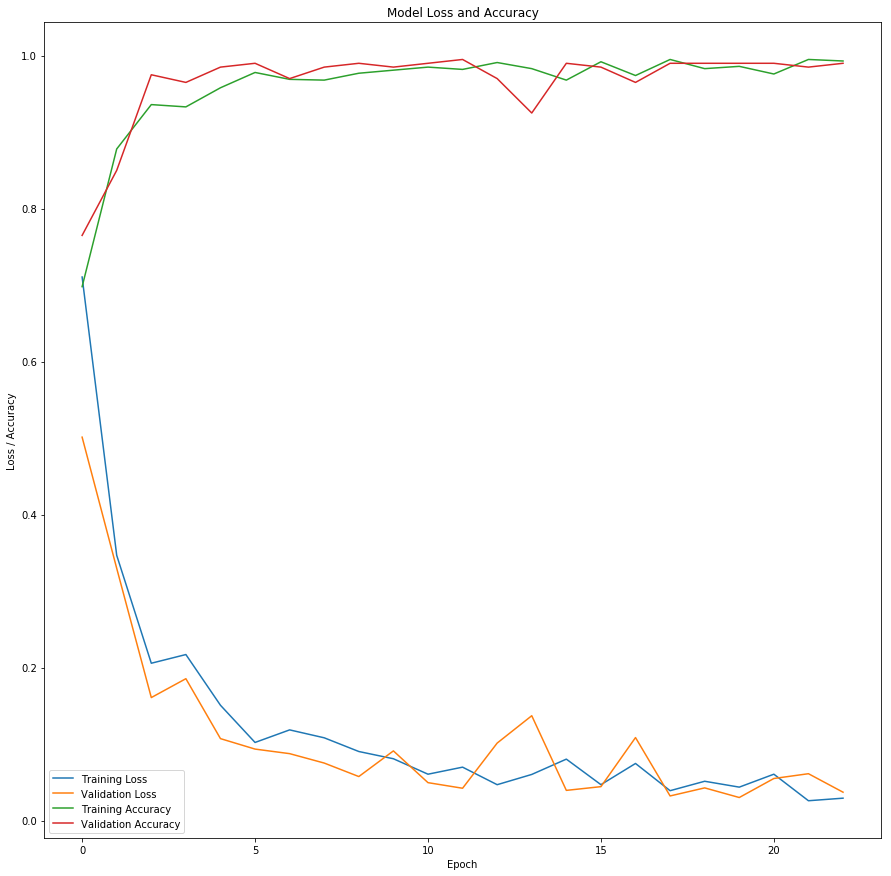

In [60]:
plt.figure(figsize=(15,15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Loss and Accuracy')
plt.ylabel('Loss / Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy'])

## Udacity Real Test Track Traffic Light Bag Accuracy

In [61]:
import ntpath
import time

def generate_test(color, FLAGS):
    image_files = glob.glob("data/traffic_light_bag_files/combined/" + str(color) + "/*.jpg")
    total_color = len(image_files)
    print("Starting " + str(color) + " images.")
    then = time.time()
    
    correct = 0
    for image_path in image_files:
        filename = ntpath.basename(image_path)

        image = cv2.imread(image_path)
        image_copy = image.copy()

        if image.shape != FLAGS['IMAGE_SIZE']:
            image = cv2.resize(image, FLAGS['IMAGE_SIZE'], interpolation=cv2.INTER_CUBIC)

        result = model.predict(image[None, :, :, :], batch_size=1)

        prediction = np.argmax(result)
        if(get_label_name(prediction, 
                          FLAGS['ENABLE_NONE'], 
                          FLAGS['DEBUG'], 
                          FLAGS['ENABLE_YELLOW'], 
                          FLAGS['ENABLE_GREEN']) == color):
            correct += 1

    now = time.time()
    diff = now - then
    print("Time Passed ", diff)
    print("FPS ", total_color / diff)

    print("Done with", correct, "out of", total_color, "correct.")
    print((correct / total_color))
    print()


generate_test("red", FLAGS)
generate_test("yellow", FLAGS)
generate_test("green", FLAGS)
generate_test("none", FLAGS)

print()
print(FLAGS)

Starting red images.
Time Passed  9.208683013916016
FPS  35.07559110373194
Done with 218 out of 323 correct.
0.6749226006191951

Starting yellow images.
Time Passed  3.661583662033081
FPS  36.32308101521084
Done with 132 out of 133 correct.
0.9924812030075187

Starting green images.
Time Passed  13.473571062088013
FPS  34.43778919945025
Done with 385 out of 464 correct.
0.8297413793103449

Starting none images.
Time Passed  26.66085958480835
FPS  34.84508806045228
Done with 110 out of 929 correct.
0.11840688912809473


{'FLOW_FROM_DIRECTORY': True, 'ENABLE_BOSCH': False, 'BOSCH_MARGIN': 10, 'BOSCH_TRAIN': 'data/cropped_data/train_margin10', 'BOSCH_ADDITIONAL': 'data/cropped_data/additional_train_margin10', 'BOSCH_TEST': 'data/cropped_data/test_margin10', 'USE_SIM_BAG': False, 'SIM_DATA_PATH': 'data/sim_bag_files/images_2017-11-13-19-27-52', 'USE_REAL_BAG': False, 'REAL_BAG_PATH': 'data/traffic_light_bag_files/images_just_traffic_light/unseperated', 'USE_IMPERFECT': False, 'IMPERFECT_PA

In [62]:
# del model
# K.clear_session()
# gc.collect()